In [40]:
# imports

import os
import subprocess
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

print("PyTorch version = {} ".format(torch.__version__))

PyTorch version = 0.4.0 


In [41]:
all_data = np.array([
    [-1.0000, -1.0000, -1.0000], 
    [-1.0000, 1.0000, 1.0000],
    [1.0000, -1.0000, 1.0000],
    [1.0000, 1.0000, -1.0000]
])

np.random.shuffle(all_data)

train_x = all_data[0:,0:2]
train_y = all_data[0:,2].reshape(-1, 1)

In [42]:
# define hyperparams

class LRConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 epochs=3,
                 learning_rate=0.01,
                 momentum=0.1,
                 weight_decay=0.1,
                 architecture=[100, 3]):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.architecture = architecture
        self.weight_decay = weight_decay
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        status += "architecture = {}\n".format(self.architecture)
        status += "weight_decay = {}\n".format(self.weight_decay)

        return status

In [60]:
# set hyperparams

lr_config = LRConfig()
lr_config.epochs = 1000
lr_config.learning_rate = 0.2
lr_config.momentum = 0
lr_config.architecture = [1, 1]
lr_config.weight_decay = 0
print("Os hiper parâmetros do modelo de regressão logística são:\n")
print(lr_config)

Os hiper parâmetros do modelo de regressão logística são:

epochs = 1000
learning_rate = 0.2
momentum = 0
architecture = [1, 1]
weight_decay = 0



In [61]:
# organizing data

class DataHolder():
    """
    Class to store all data.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset):
                
        self.train_loader = DataLoader(dataset=train_dataset,
                                       batch_size=len(train_dataset),
                                       shuffle=True)

train_dataset = TensorDataset(torch.Tensor(train_x),
                              torch.Tensor(train_y))

self_driving_data = DataHolder(lr_config, train_dataset) 

In [62]:
# define DFN model

class DFN(nn.Module):

    def __init__(self, config):
        super(DFN, self).__init__()
        self.classes = 1
        self.params = 2
        self.num_layers = len(config.architecture)
        p_in = self.params
        for step, layer in enumerate(config.architecture):
            p_out = layer
            self.add_module("lin"+str(step), nn.Linear(p_in, p_out))
            self.add_module("relu"+str(step), nn.Tanh())
            p_in = p_out
        self.add_module("softmax", nn.Softmax(1))


    def forward(self, x):
        """
        Computes forward pass

        :param x: input tensor
        :type x: torch.FloatTensor(shape=(batch_size, number_of_features))
        :return: logits
        :rtype: torch.FloatTensor(shape=[batch_size, number_of_classes])
        """
        inn = x
        for i in range(self.num_layers):
            linear = getattr(self, "lin"+str(i))
            mid = linear(inn)
            relu = getattr(self, "relu"+str(i))
            out = relu(mid)
            inn = out
        logits = out
        return logits

    def predict(self, x):
        logits = self.forward(x)
        probs = self.softmax(logits)
        predictions = probs.argmax(dim=1)
        return predictions

In [69]:
# model trainer

def train_model_classification(model,
                                   config,
                                   dataholder,
                                   criterion, 
                                   optimizer):

    train_loader = dataholder.train_loader

    train_loss = []
    for epoch in range(config.epochs):
        for step, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = model(images)
            loss = criterion(pred, labels) 
                    
            loss.backward()
            optimizer.step()
            
            if step % 10 == 0:
                train_loss.append(float(loss))
 
                        
    # Plot
    x = np.arange(1, len(train_loss) + 1, 1)
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.plot(x, train_loss, label='Energia TT')
    ax.legend()
    plt.ylim(0, 1.2)
    plt.xlabel('época')
    plt.ylabel('energia')
    plt.title('Energia TT (ii=1)')
    plt.grid(True)
    plt.show()
        



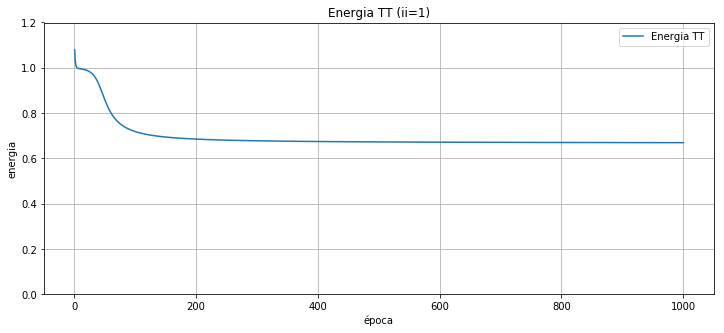

In [70]:
model = DFN(lr_config)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr_config.learning_rate, lr_config.momentum, weight_decay=lr_config.weight_decay)

train_model_classification(model,
                               lr_config,
                               self_driving_data,
                               criterion,
                               optimizer)